# PART I

In [4]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# define base path for data files

BasePath="/content/drive/MyDrive/springboard/ultimate_challenge/ultimate_challenge"

#define file path for login data

LoginPath = f"{BasePath}/logins.json"

# load login data from JSON file
logins = pd.read_json(LoginPath)

# display first few rows
logins.head()



Mounted at /content/drive


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
# Check dataframe shape and column types
logins.shape, logins.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


((93142, 1), None)

In [9]:
# Set login_time as index for time based operations
logins_ts = logins.set_index("login_time")


# Aggregate login events into 15-min intervals
logins_15m = (
    logins_ts
    .resample("15min")
    .size()
    .to_frame(name="login_count")

)



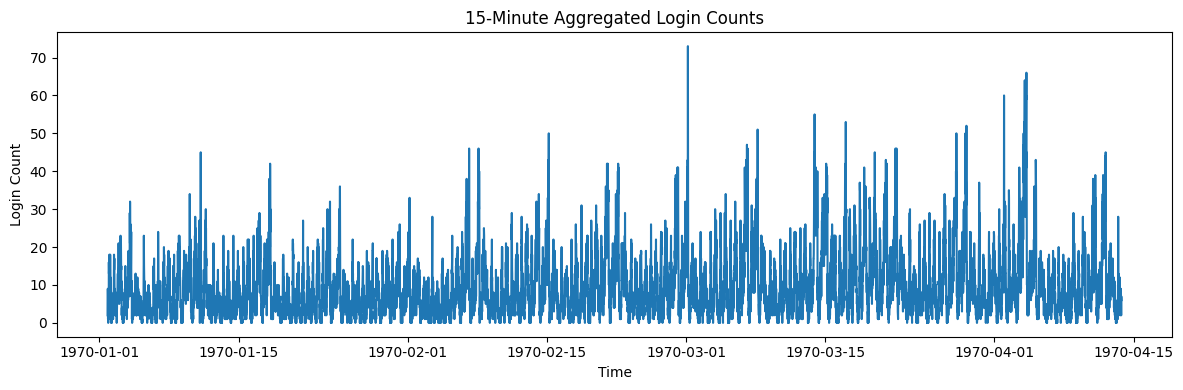

In [11]:
import matplotlib.pyplot as plt

# Plot 15 min aggregated login counts over time
plt.figure(figsize=(12,4))
plt.plot(logins_15m.index, logins_15m["login_count"])
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.title("15-Minute Aggregated Login Counts")
plt.tight_layout()
plt.show()


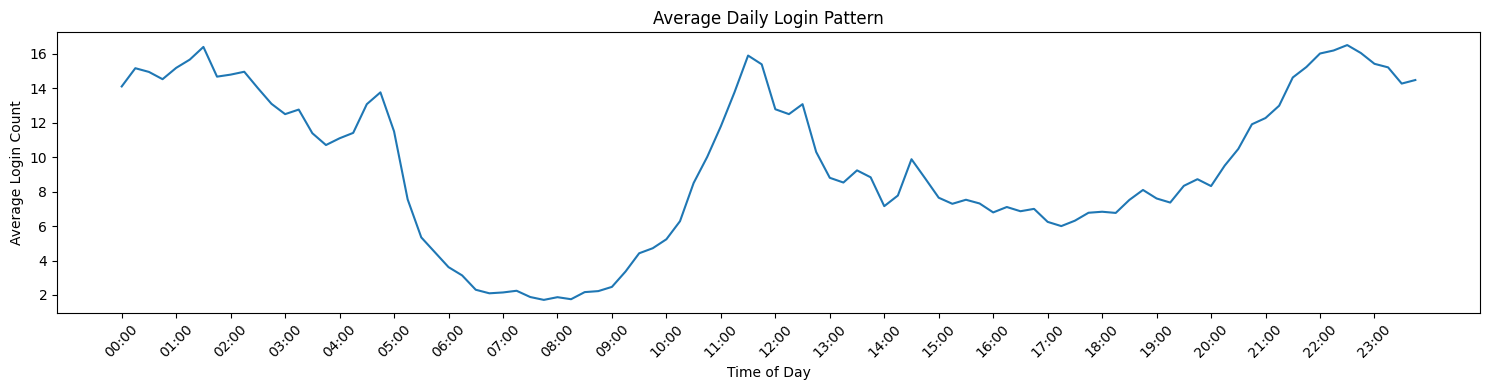

In [15]:

# Extract time-of-day from the datetime index
logins_15m["time_of_day"] = logins_15m.index.time

# Compute average login count for each 15-min time-of-day bucket
daily_patterns = (
    logins_15m
    .groupby("time_of_day")["login_count"]
    .mean()
)

# Convert time objects to strings for plotting
x_labels = [t.strftime("%H:%M") for t in daily_patterns.index]

# Plot average daily login pattern
plt.figure(figsize=(15, 4))
plt.plot(x_labels, daily_patterns.values)

# Show fewer x-ticks to keep the plot readable (every hour)
tick_step = 4  # 4 * 15min = 60min
plt.xticks(range(0, len(x_labels), tick_step), x_labels[0::tick_step], rotation=45)

plt.xlabel("Time of Day")
plt.ylabel("Average Login Count")
plt.title("Average Daily Login Pattern")
plt.tight_layout()
plt.show()


**Observations from Login Time Series**



*   Login activity shows a clear daily seasonality, indicating strong time-of-day effects in user behavior.

*   Activity is lowest during early morning hours (approximately 06:00–09:00), suggesting reduced platform usage overnight.

*   There is a pronounced increase around late morning to midday, followed by a moderate decline in the afternoon.

*   A second strong peak occurs during late evening hours (approximately 21:00–23:00), which appears to be the highest activity period on average.

*   These patterns are consistent across days, suggesting stable and repeatable user behavior rather than isolated spikes.










# PART II

Gotham and Metropolis have opposite peak demand hours, but a toll bridge prevents drivers from freely moving between cities. Reimbursing toll costs is proposed to remove this friction and improve supply utilization across both cities.

1)

**Primary Metric:**

Percentage of active drivers who complete at least one trip in both Gotham and Metropolis during the experiment period.

Rationale:
The primary objective of the experiment is to encourage driver partners to be available in both cities by reducing the friction associated with crossing the toll bridge. Measuring the proportion of drivers who actually complete trips in both cities directly captures this intended behavioral change.

Using total completed trips as the primary metric can be misleading, as overall trip volume may increase due to unrelated factors such as demand fluctuations, weather, or local events, without meaningfully changing driver cross-city behavior. By contrast, the share of multi-city drivers isolates the causal mechanism of the intervention and provides a clearer signal of whether toll reimbursement successfully alters driver availability patterns.

**Secondary Metrics (for validation and guardrails):**

Total completed trips across both cities

Net contribution margin after toll reimbursements

Average pickup ETA and cancellation rate

Tracking these secondary metrics ensures that the observed behavioral change translates into improved system performance and sustainable business outcomes.

2.
**a) How I would implement the experiment**

I would run a driver-level randomized A/B test to isolate the effect of toll reimbursement on cross-city driver behavior.

Active drivers in Gotham and Metropolis would be randomly assigned to one of two groups:

Control: drivers continue paying bridge tolls as usual.

Treatment: drivers receive full reimbursement for bridge tolls during the experiment.

Randomizing at the driver level ensures consistent exposure to the incentive and avoids behavioral contamination.

Given the complementary demand patterns, the experiment would focus on weekends and run for multiple consecutive weekends (e.g., four) to capture stable behavior and avoid short-term novelty effects.

Drivers in the treatment group would receive clear in-app communication about the reimbursement, and reimbursements would be processed automatically and promptly. For both groups, we would track completed trips by city and whether drivers served both cities within the experiment window, along with reimbursement costs. Basic caps or eligibility rules could be applied to limit abuse.


**b) Statistical Tests**

To verify the significance of the experiment results, I would use a simple hypothesis testing approach based on the primary metric.

Primary test:
I would use a two-proportion z-test to compare the proportion of drivers who serve both Gotham and Metropolis in the treatment group versus the control group.

Why:
The primary metric is binary (whether a driver serves both cities or not), and we are comparing two independent groups created through random assignment. The two-proportion z-test is appropriate and easy to interpret for this scenario.

Significance criteria:
I would use a significance level of α = 0.05. If the p-value is below this threshold, I would conclude that toll reimbursement has a statistically significant effect on cross-city driver participation.

In addition to statistical significance, I would also look at the size of the difference in proportions to ensure the effect is meaningful from a practical standpoint.



**c) Interpretation and Recommendations**

Interpretation: If the treatment group shows a statistically significant increase in drivers serving both cities, I would conclude that toll reimbursement is effective. Crucially, I would calculate the ROI by comparing the incremental revenue against the reimbursement cost. If no significant difference is observed, tolls are likely not the primary friction point.

Recommendations:

Positive & Cost-Effective: Full rollout, focusing on weekends to maximize efficiency.

Positive but Costly: Evaluate as a "Loss Leader" strategy; proceed only if it significantly improves service reliability and user retention.

No Significant Effect: Terminate the program and pivot to alternative incentives (e.g., Guaranteed Earnings).

Caveats:

Cannibalization: Ensure net growth rather than just shifting supply from one city to another.

Seasonality: Results may be specific to the experiment period (e.g., weather).

Fraud: Drivers might cross solely for reimbursement without working.


# PART III

**Part 3.1 Cleaning & EDA**


In [16]:
import pandas as pd

#load dataset
BasePath3 = "/content/drive/MyDrive/springboard/ultimate_challenge/ultimate_challenge"
DataPath3 = f"{BasePath}/ultimate_data_challenge.json"

df = pd.read_json(DataPath3)

print(df.shape)
df.head()

(50000, 12)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
# Convert date columns to datetime
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"], errors="coerce")

# Check the result
df[["signup_date", "last_trip_date"]].head()


,signup_date,last_trip_date
0,2014-01-25,2014-06-17
1,2014-01-29,2014-05-05
2,2014-01-06,2014-01-07
3,2014-01-10,2014-06-29
4,2014-01-27,2014-03-15


In [20]:
# Approximate the data pull date as the most recent trip date
data_pull_date = df["last_trip_date"].max()

#Define retention cutoff (last 30 days before data pull)
cutoff_date= data_pull_date - pd.Timedelta(days=30)

# Create retained label
df["retained"] = (df["last_trip_date"] >= cutoff_date).astype(int)

# Quick check
print("Data pull date:", data_pull_date)
print("cutoff date:", cutoff_date)
df["retained"].value_counts()

Data pull date: 2014-07-01 00:00:00
cutoff date: 2014-06-01 00:00:00


,count
retained,
0,31196
1,18804


In [21]:
# Calculate retention rate
retention_rate = df["retained"].mean()

retention_rate


np.float64(0.37608)

In [22]:
# Check missing values per column
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df) * 100)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
}).sort_values(by="missing_count", ascending=False)

missing_summary

,missing_count,missing_pct
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
avg_surge,0,0.000
signup_date,0,0.000
surge_pct,0,0.000
last_trip_date,0,0.000
ultimate_black_user,0,0.000


In [26]:
# Impute missing values

# Numeric rating columns -> median

df["avg_rating_of_driver"] = df["avg_rating_of_driver"].fillna(
    df["avg_rating_of_driver"].median()
)

df["avg_rating_by_driver"] = df["avg_rating_by_driver"].fillna(
    df["avg_rating_by_driver"].median()
)

# Categorical column -> "Unknown"

df["phone"] = df["phone"].fillna("Unknown")

# Sanity check
df.isna().sum()


,0
city,0
trips_in_first_30_days,0
signup_date,0
avg_rating_of_driver,0
avg_surge,0
last_trip_date,0
phone,0
surge_pct,0
ultimate_black_user,0
weekday_pct,0


In [27]:
for col in ["city", "phone", "ultimate_black_user"]:
  print(f"/nCloumn: {col}")
  print(df[col].value_counts())

/nCloumn: city
city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64
/nCloumn: phone
phone
iPhone     34582
Android    15022
Unknown      396
Name: count, dtype: int64
/nCloumn: ultimate_black_user
ultimate_black_user
False    31146
True     18854
Name: count, dtype: int64


In [28]:
# Encode binary variable
df["ultimate_black_user"] = df["ultimate_black_user"].astype(int)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df,
    columns=["city", "phone"],
    drop_first=True
)

# Quick check
df_encoded.head()


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,True,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,False,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,True,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,False,True,False,False


In [29]:
# Convert boolean dummy columns to int
bool_cols = df_encoded.select_dtypes(include="bool").columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Check result
df_encoded[bool_cols].head()


,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone
0,1,0,0,1
1,0,0,0,0
2,0,0,0,1
3,1,0,0,1
4,0,1,0,0


In [31]:
# Define target
y = df_encoded["retained"]

# Define features (drop target and date columns)
X = df_encoded.drop(
    columns=["retained", "signup_date", "last_trip_date"]
)

print(X.shape)
print(y.shape)


(50000, 12)
(50000,)


In [32]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Check shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (37500, 12)
X_test : (12500, 12)
y_train: (37500,)
y_test : (12500,)


**Part 3.2 Predictive Modeling**

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Train a baseline logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7152
ROC-AUC : 0.7552121412322508

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      7799
           1       0.66      0.49      0.57      4701

    accuracy                           0.72     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.72      0.70     12500



I framed this as a binary classification problem to predict whether a user will be active in their 6th month and used a Logistic Regression model as a simple, interpretable baseline. After cleaning the data, handling missing values, encoding categorical variables, and avoiding date leakage, the model achieved an accuracy of 71.5% and a ROC-AUC of 0.76, which is a clear improvement over a majority-class baseline. These results indicate that the model captures meaningful signals related to retention, although recall for retained users is relatively low at the default threshold. I chose this approach for its transparency and speed, while recognizing that more complex models such as tree-based methods could potentially improve performance. Key concerns include class imbalance and the assumption used to define the retention label, but overall the model is a valid and informative baseline for predicting user retention.

**Part 3.3) Business Insights and Retention Strategy**

Ultimate can use the model’s predicted retention probabilities to identify users who are at high risk of churn early in their lifecycle. These users can be targeted with personalized interventions such as ride credits, promotions, or improved service availability during their typical usage times. Additionally, insights from key features (e.g., early trip frequency or surge exposure) can help guide product and pricing decisions to improve the overall rider experience and encourage long-term engagement.